In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Polygon, Point


In [2]:
def load_maps_and_regions():
    # Load the Zambezia region shapefile
    moz_regions = gpd.read_file("world_shp/mz.shp")

    # Load the Zambezia districts shapefile
    zambezia_districts = gpd.read_file("mz_adm/moz_admbnda_adm2_ine_20190607.shp")

    # Create a plot
    fig = plt.figure(figsize=(12, 8*1.2))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

    # Set map extent to focus on Zambezia
    x_min, x_max, y_min, y_max = 34, 40, -19, -14
    vertices = [(x_min, y_min), (x_max, y_min), (x_max, y_max), (x_min, y_max)]
    defined_region = Polygon(vertices)
    ax.set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())


    # Add background map
    ax.add_feature(cfeature.LAND, color='lightgray')
    ax.add_feature(cfeature.OCEAN, color='lightcyan')#cfeature.COLORS['water'])
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.RIVERS)
    ax.add_feature(cfeature.LAKES, edgecolor='none', color='lightcyan')

    # Plot Zambezia districts boundaries
    # ax.add_geometries(zambezia_districts['geometry'], crs=ccrs.PlateCarree(),
    #                 edgecolor='darkgray', linestyle='-', facecolor='none', linewidth=0.5)
    ax.add_geometries(zambezia_districts[zambezia_districts.ADM1_PT=='Zambezia']['geometry'], crs=ccrs.PlateCarree(),
                    edgecolor='dimgray', linestyle='-', facecolor='none', linewidth=1)

    # Plot Zambezia region boundary
    ax.add_geometries(moz_regions['geometry'], crs=ccrs.PlateCarree(), edgecolor='black', linestyle='-', facecolor='none')
    
    # moz_regions['color'] = np.where(moz_regions['name']=='Zambezia', 'lightgray', 'darkgrey') # Different gray tone for inside or outside Zambezia
    moz_regions['color'] = 'lightgray' # np.where(moz_regions['name']=='Zambezia', 'darkgrey', 'darkgrey')
    zambezia_region = moz_regions[moz_regions['name']=='Zambezia']['geometry'].unary_union            
    moz_regions.plot(color=moz_regions['color'], ax=ax)

    mw_regions = gpd.read_file("world_shp/mw.shp")
    mw_regions.dissolve().plot(color='dimgray', edgecolor="black", ax=ax)
    return ax, defined_region, zambezia_region, zambezia_districts

In [3]:
def load_roads(ax, defined_region, zambezia_region, output_folder = "generated_shp"):
    # Execute only if first time
    if not os.path.exists(os.path.join(output_folder,"our_roads_all_cat.shp")):
        if not os.path.isdir(output_folder):
            os.mkdir(output_folder)
        # Load the roads shapefile
        gdf = gpd.read_file("mz_shp/gis_osm_roads_free_1.shp")
        # Keep only gdf inside our defind region
        gdf = gdf[gdf.geometry.within(defined_region)]
        gdf.to_file(os.path.join(output_folder,"our_roads_all_cat.shp"))
        
    if os.path.exists(os.path.join(output_folder,"our_roads.shp")):
        gdf = gpd.read_file("generated_shp/our_roads.shp")
        save = False
    else:
        gdf = gpd.read_file("generated_shp/our_roads_all_cat.shp")
        save = True
    '''
    Plot roads, possible fclasses:
        'unclassified', 'residential', 'secondary', 'tertiary', 'primary', 'trunk',
        'track_grade3', 'track_grade4', 'primary_link', 'service', 'track_grade5',
        'trunk_link', 'footway', 'track', 'path', 'secondary_link', 'steps', 'tertiary_link',
        'living_street', 'pedestrian', 'track_grade2', 'bridleway', 'track_grade1', 'cycleway', 'unknown'
    '''
    target_fclasses = ['trunk', 'primary', 'primary_link', 'secondary', 'secondary_link']
    for i, road in gdf[gdf['fclass'].isin(target_fclasses)].iterrows():
        color = {}
        for j in target_fclasses:
            color[j] = 'lightcoral' if j.startswith('secondary') else 'firebrick'
        # Uncomment for different colors inside/outside Zambezia region
        # if zambezia_region.contains(road['geometry']):
        #     color = {
        #         'trunk' : 'brown',
        #         'primary': 'firebrick',
        #         'primary_link': 'firebrick',
        #         'secondary': 'lightcoral',
        #         'secondary_link': 'lightcoral'
        #     }
        ax.add_geometries([road['geometry']], crs=ccrs.PlateCarree(), edgecolor=color[road['fclass']], linewidth=1, facecolor='none')

    if save:
        gdf[gdf['fclass'].isin(target_fclasses)].to_file(os.path.join(output_folder,"our_roads.shp"))
        
    return ax

# define an object that will be used by the legend
class MulticolorPatch(object):
    def __init__(self, colors):
        self.colors = colors
        
# define a handler for the MulticolorPatch object
class MulticolorPatchHandler(object):
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        width, height = handlebox.width, handlebox.height
        patches = []
        for i, c in enumerate(orig_handle.colors):
            patches.append(plt.Rectangle([width/len(orig_handle.colors) * i - handlebox.xdescent, 
                                          -handlebox.ydescent],
                           width / len(orig_handle.colors),
                           2, 
                           facecolor=c, 
                           edgecolor='none'))

        patch = PatchCollection(patches,match_original=True)

        handlebox.add_artist(patch)
        return patch


In [4]:
def load_waterways(ax, defined_region):
    gdf = gpd.read_file("mz_shp/gis_osm_waterways_free_1.shp")
    # Keep only gdf inside our defind region
    gdf = gdf[gdf.geometry.within(defined_region)]
    river_list = ['Zambeze', 'Licungo', 'Rio Licungo']
    target_fclasses = ['river']
    for i, water in gdf[gdf['fclass'].isin(target_fclasses)].iterrows():
        if water.name in river_list:
            ax.add_geometries([water['geometry']], crs=ccrs.PlateCarree(), edgecolor=cfeature.COLORS['water'], linewidth=1, facecolor='none')
    return ax

In [5]:
def load_health_facilities(ax):
    # Load the health facilities
    gdf = gpd.read_file("mz-health-facilities/mozambique-healthfacilities.shp")
    # Keep only gdf inside Zambezia region, where CP is 4
    gdf = gdf[gdf.CP==4]
    '''
    CC translation:
    CLASSIFICATION              CC
    Centro de Saúde Rural I     11
    Centro de Saúde Rural II    12
    Centro de Saúde Urbano A     8
    Centro de Saúde Urbano B     9
    Centro de Saúde Urbano C    10
    Centro de saúde mental      14
    Hospital Distrital           6
    Hospital Provincial          3
    Hospital Rural               5
    Posto de Saúde              13
    '''
    health_admin_levels = {
            1: [3],
            2: [6, 5],
            3: [8, 9, 10, 11, 12, 13, 14],
        }
    color = {
            1: 'olive',
            2: 'olive',
            3: 'darkkhaki',
        }
    for i, place in gdf.iterrows():
        level = next((key for key, value in health_admin_levels.items() if int(place.CC) in value), 13)
        ms = 10-2*level
        ax.plot(place.geometry.x, place.geometry.y, "o", color=color[level],
                markersize=ms, transform=ccrs.Geodetic())
    return ax

In [6]:
def load_places(ax, defined_region, places_namelist="printed_places.txt",
                places_namelist_no_name="printed_places_NO_NAME.txt"):
    gdf = gpd.read_file("mz_shp/gis_osm_places_free_1.shp")
    # Keep only gdf inside defined region
    gdf = gdf[gdf.geometry.within(defined_region)]

    if not os.path.exists(places_namelist):
        places_namelist = []
    else:
        with open(places_namelist, 'r') as file:
            places_list = file.read().splitlines()

    if not os.path.exists(places_namelist_no_name):
        places_namelist_no_name = []
    else:
        with open(places_namelist_no_name, 'r') as file:
            places_namelist_no_name = file.read().splitlines()

    '''
    Plot places, possible fclasses:
        'city', 'national_capital', 'locality', 'hamlet', 'town',
        'village', 'suburb', 'farm', 'island'
    '''
    target_fclasses = ['city', 'national_capital', 'town', 'village']
    for i, place in gdf[gdf['fclass'].isin(target_fclasses)].iterrows():
        point_x = place['geometry'].x
        point_y = place['geometry'].y
        if place.fclass=='city' or (place['name'] in places_list if places_list else True):
            fs = 12 if place['fclass']=='city' else 10
            ax.plot(point_x, point_y, ".", color="black", transform=ccrs.Geodetic())
            ha = 'left'
            va = 'bottom'
            offset = 0.0
            ax.text(point_x+0.02, point_y+offset, place['name'], fontsize=fs, ha=ha, va=va, transform=ccrs.Geodetic())
        elif place['name'] in places_namelist_no_name:
             ax.plot(point_x, point_y, ".", color="black", transform=ccrs.Geodetic())

    return ax

In [7]:
def load_study_data(ax, zambezia_districts, filename="Case_series.csv", delimiter=';',
                    decimal=',', case_color="#CDCD00", markeredgecolor='darkgreen'):
    
    visited_color = 'ivory'
    # visited_color = (136, 204, 238, 1)
    
    if not os.path.exists(filename):
        raise FileNotFoundError
    else:
        if filename.endswith('.csv'):
            df = pd.read_csv(filename, delimiter=delimiter, decimal=decimal)
        elif  filename.endswith('.xlsx'):
            df = pd.read_excel(filename, decimal=decimal)
            df[['latitude', 'longitude']] = df[['lat_dis', 'lon_dis']]
        else:
            raise ValueError("Format not supported")
    # already done with 'decimal' parameter
    # df[['latitude', 'longitude']] = df[['latitude', 'longitude']].map(lambda x: float(x.replace(',', '.')) if isinstance(x, str) else x)

    for lat, lon in zip(df["latitude"],df["longitude"]):
        if lat is not np.nan and lon is not np.nan:
            # ax.plot(lon, lat, marker="d", color=(57/255, 46/255, 74/255, 0.8), transform=ccrs.Geodetic())
            ax.plot(lon, lat, marker="d", color=case_color, markeredgecolor=markeredgecolor, transform=ccrs.Geodetic())
        
    # Add color to visited districts
    zambezia_districts['color'] ='lightgray'
    zambezia_districts_strict = zambezia_districts[zambezia_districts.ADM1_PT=='Zambezia']
    for lat, lon in zip(df["latitude"],df["longitude"]):
        p = Point(lon, lat)

        if p:
            for index, district_row in zambezia_districts_strict.iterrows():
                if district_row['geometry'].contains(p):
                    zambezia_districts_strict.loc[index, 'color'] = visited_color
    
    # Namarroi wasn't visited although cases were reported there
    zambezia_districts_strict.loc[zambezia_districts_strict.ADM2_PT=='Namarroi', 'color'] = 'lightgray'
    # Gurue and Nicoadala were visited but not cases reported
    zambezia_districts_strict.loc[zambezia_districts_strict.ADM2_PT=='Gurue', 'color'] = visited_color
    zambezia_districts_strict.loc[zambezia_districts_strict.ADM2_PT=='Nicoadala', 'color'] = visited_color
    zambezia_districts_strict.plot(color=zambezia_districts_strict['color'], ax=ax)
    return ax


_____

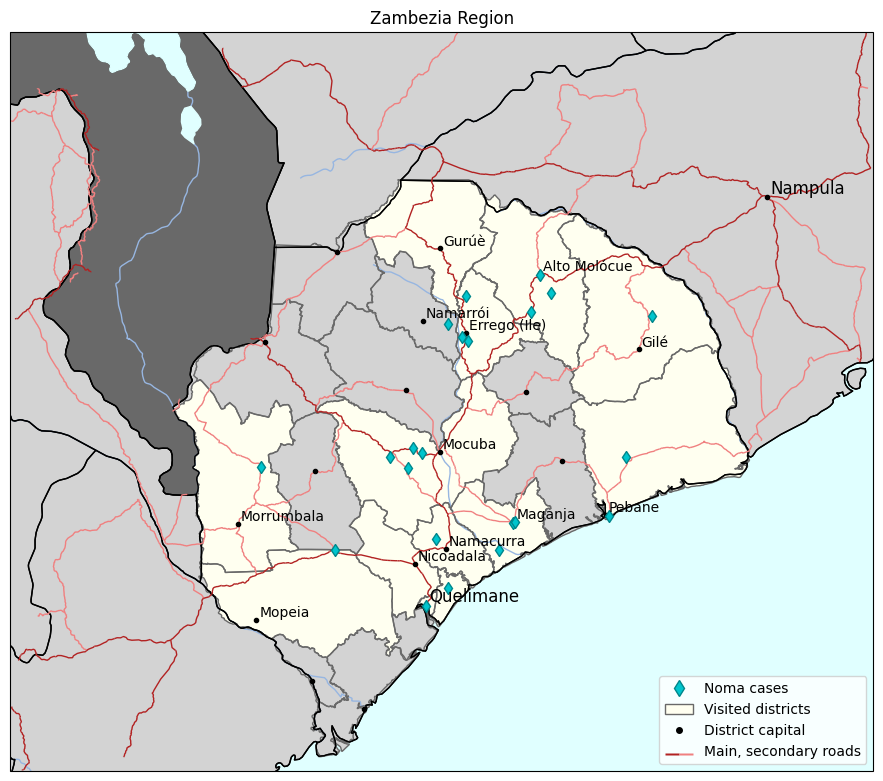

In [9]:
ax, defined_region, zambezia_region, zambezia_districts = load_maps_and_regions()
ax = load_roads(ax, defined_region, zambezia_region)
ax = load_waterways(ax, defined_region)
# ax = load_health_facilities(ax) # Decided to not show in the latest version
ax = load_places(ax, defined_region)
ax = load_study_data(ax, zambezia_districts, case_color="#00c5cd", markeredgecolor='#00868b')


####################################################################################################################

# Create custom legend entries
visited_districts_patch = Patch(facecolor='ivory', edgecolor='dimgray', label='Visited districts')
cases_handle = Line2D([], [], marker='d', color='none', markerfacecolor="#00c5cd",
                      markeredgecolor="#00868b", markersize=8, label="Noma cases")
capitals_handle = Line2D([], [], marker='.', color='none',markerfacecolor="black",
                      markeredgecolor="black", markersize=8, label="District capital")
handles = [cases_handle, visited_districts_patch, capitals_handle]
labels = [h.get_label() for h in handles]
# Aggregate into single legend entry main and secondary roads
combined_roads_patch = MulticolorPatch(['firebrick', 'lightcoral'])
handles.append(combined_roads_patch)
labels.append('Main, secondary roads')
# main_roads_line = Line2D([], [], color='firebrick', linestyle='-', linewidth=2, label='Main roads')
# secondary_roads_line = Line2D([], [], color='lightcoral', linestyle='-', linewidth=2, label='Secondary roads')
# handles.extend([main_roads_line, secondary_roads_line])
# labels.extend([main_roads_line.get_label(), secondary_roads_line.get_label()])

ax.legend(handles, labels, loc='lower right',
         handler_map={MulticolorPatch: MulticolorPatchHandler()})

####################################################################################################################

mw_regions = gpd.read_file("world_shp/mw.shp")
mw_regions.dissolve().plot(color='dimgray', edgecolor="black", ax=ax)

# Set plot title
plt.title("Zambezia Region")

plt.savefig("zambezia_districts_map.pdf", bbox_inches='tight')

# Show plot
plt.show()
